#Download Dataset

In [9]:
!kaggle competitions download -c feedback-prize-english-language-learning

  0% 0.00/2.80M [00:00<?, ?B/s]
100% 2.80M/2.80M [00:00<00:00, 158MB/s]


In [10]:
!unzip feedback-prize-english-language-learning.zip

Archive:  feedback-prize-english-language-learning.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [11]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 46.0 MB/s 
     |████████████████████████████████| 120 kB 60.3 MB/s 


#Import Packages

In [12]:
import pandas as pd
import numpy as np
import os
import string
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

#Preprocessing Dataset

In [13]:
train_dataset = pd.read_csv("train.csv")
train_dataset.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [15]:
train_dataset.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [16]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      3911 non-null   object 
 1   full_text    3911 non-null   object 
 2   cohesion     3911 non-null   float64
 3   syntax       3911 non-null   float64
 4   vocabulary   3911 non-null   float64
 5   phraseology  3911 non-null   float64
 6   grammar      3911 non-null   float64
 7   conventions  3911 non-null   float64
dtypes: float64(6), object(2)
memory usage: 244.6+ KB


In [48]:
full_text = train_dataset['full_text']
cohesion = train_dataset['cohesion']
syntax = train_dataset['syntax']
vocabulary = train_dataset['vocabulary']
phraseology = train_dataset['phraseology']
grammar = train_dataset['grammar']
conventions = train_dataset['conventions']

In [49]:
full_text.shape

(3911,)

In [50]:
cohesion

0       3.5
1       2.5
2       3.0
3       4.5
4       2.5
       ... 
3906    2.5
3907    4.0
3908    2.5
3909    4.0
3910    3.5
Name: cohesion, Length: 3911, dtype: float64

In [51]:
np.unique(cohesion)

array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [53]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [54]:
def CleanFeatures(sentences):
  sentences = sentences.apply(lambda sequence:
                                            [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])
  sentences = sentences.apply(lambda wrd: ''.join(wrd))
  sentences = sentences.apply(lambda sequence:
                                            [word for word in sequence.split() if word not in stop_words])
  sentences = sentences.apply(lambda wrd: ' '.join(wrd))
  return sentences

In [55]:
full_text = CleanFeatures(full_text)

In [56]:
full_text

0       think students would benefit learning homebeca...
1       problem change let best matter happening chang...
2       dear principal u change school policy grade b ...
3       best time life become agree greatest accomplis...
4       small act kindness impact people change people...
                              ...                        
3906    believe using cellphones class education us go...
3907    working alone students argue decission proyect...
3908    problem chance best think quote cant best ever...
3909    many people disagree albert schweitzers quote ...
3910    think failure main thing people consist goals ...
Name: full_text, Length: 3911, dtype: object

#Tokenizer Input Text

In [57]:
from transformers import AutoTokenizer

In [58]:
list_words = [len(text.split()) for text in full_text]

In [62]:
seq_len = np.max(list_words)
seq_len

593

In [63]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [64]:
input_ids = []
attention_mask = []

In [65]:
for index, value in enumerate(full_text):
  tokens = tokenizer.encode_plus(value, max_length = seq_len,padding = "max_length",
                                 truncation = True, return_token_type_ids = True,
                                 return_attention_mask = True,
                                 return_tensors = 'np')
  input_ids.append(tokens['input_ids'])
  attention_mask.append(tokens['attention_mask'])

In [66]:
input_ids = np.asarray(input_ids)
attention_mask = np.asarray(attention_mask)

In [67]:
input_ids.shape

(3911, 1, 593)

In [68]:
input_ids = np.reshape(input_ids, (input_ids.shape[0], input_ids.shape[2]))
attention_mask = np.reshape(attention_mask, (attention_mask.shape[0], attention_mask.shape[2]))

In [69]:
input_ids.shape

(3911, 593)

In [70]:
len(syntax)

3911

In [71]:
syntax = np.asarray(syntax)
cohesion = np.asarray(cohesion)
vocabulary = np.asarray(vocabulary)
phraseology = np.asarray(phraseology)
grammar = np.asarray(grammar)
conventions = np.asarray(conventions)

#TFBertModel

In [72]:
from transformers import TFBertModel
bert = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [230]:
from keras.layers import LSTM, Lambda
from keras.layers.merge import add, maximum, subtract, minimum

In [229]:
def resnet(inputs, units):
  x = tf.keras.layers.LSTM(units,return_sequences = True, dropout=0.35)(inputs)
  return x

In [ ]:
units = 32
input_ids_m = tf.keras.layers.Input(shape = (seq_len, ), dtype = 'int32')
attention_mask_n = tf.keras.layers.Input(shape = (seq_len, ),  dtype = 'int32')
bert_m = bert(input_ids_m, attention_mask = attention_mask_n)[0]
x = resnet(bert_m, units)
for stack in range(3):
  for block in range(1):
    y = resnet(x, units)
    if stack > 0 and block == 0:
      x = tf.keras.layers.LSTM(units, return_sequences = True, dropout=0.35, recurrent_dropout=0.35)(x)
    x = minimum([x, y])
  units *=2
x1 = tf.keras.layers.GlobalAveragePooling1D()(x)
x2 = tf.keras.layers.GlobalMaxPool1D()(x)
x = tf.keras.layers.concatenate([x1, x2], name="our_param")
y = tf.keras.layers.Dense(1,  name='syntax')(x)
y2 = tf.keras.layers.Dense(1, name='cohesion')(x)
y3 = tf.keras.layers.Dense(1, name='vocabulary')(x)
m = tf.keras.models.Model(inputs = [input_ids_m, attention_mask_n], outputs = [y, y2, y3])      

In [86]:
m.layers[2].trainable = False

In [87]:
m.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 593)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 593)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_7[0][0]',                
                                thPoolingAndCrossAt               'input_8[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 593,                                         

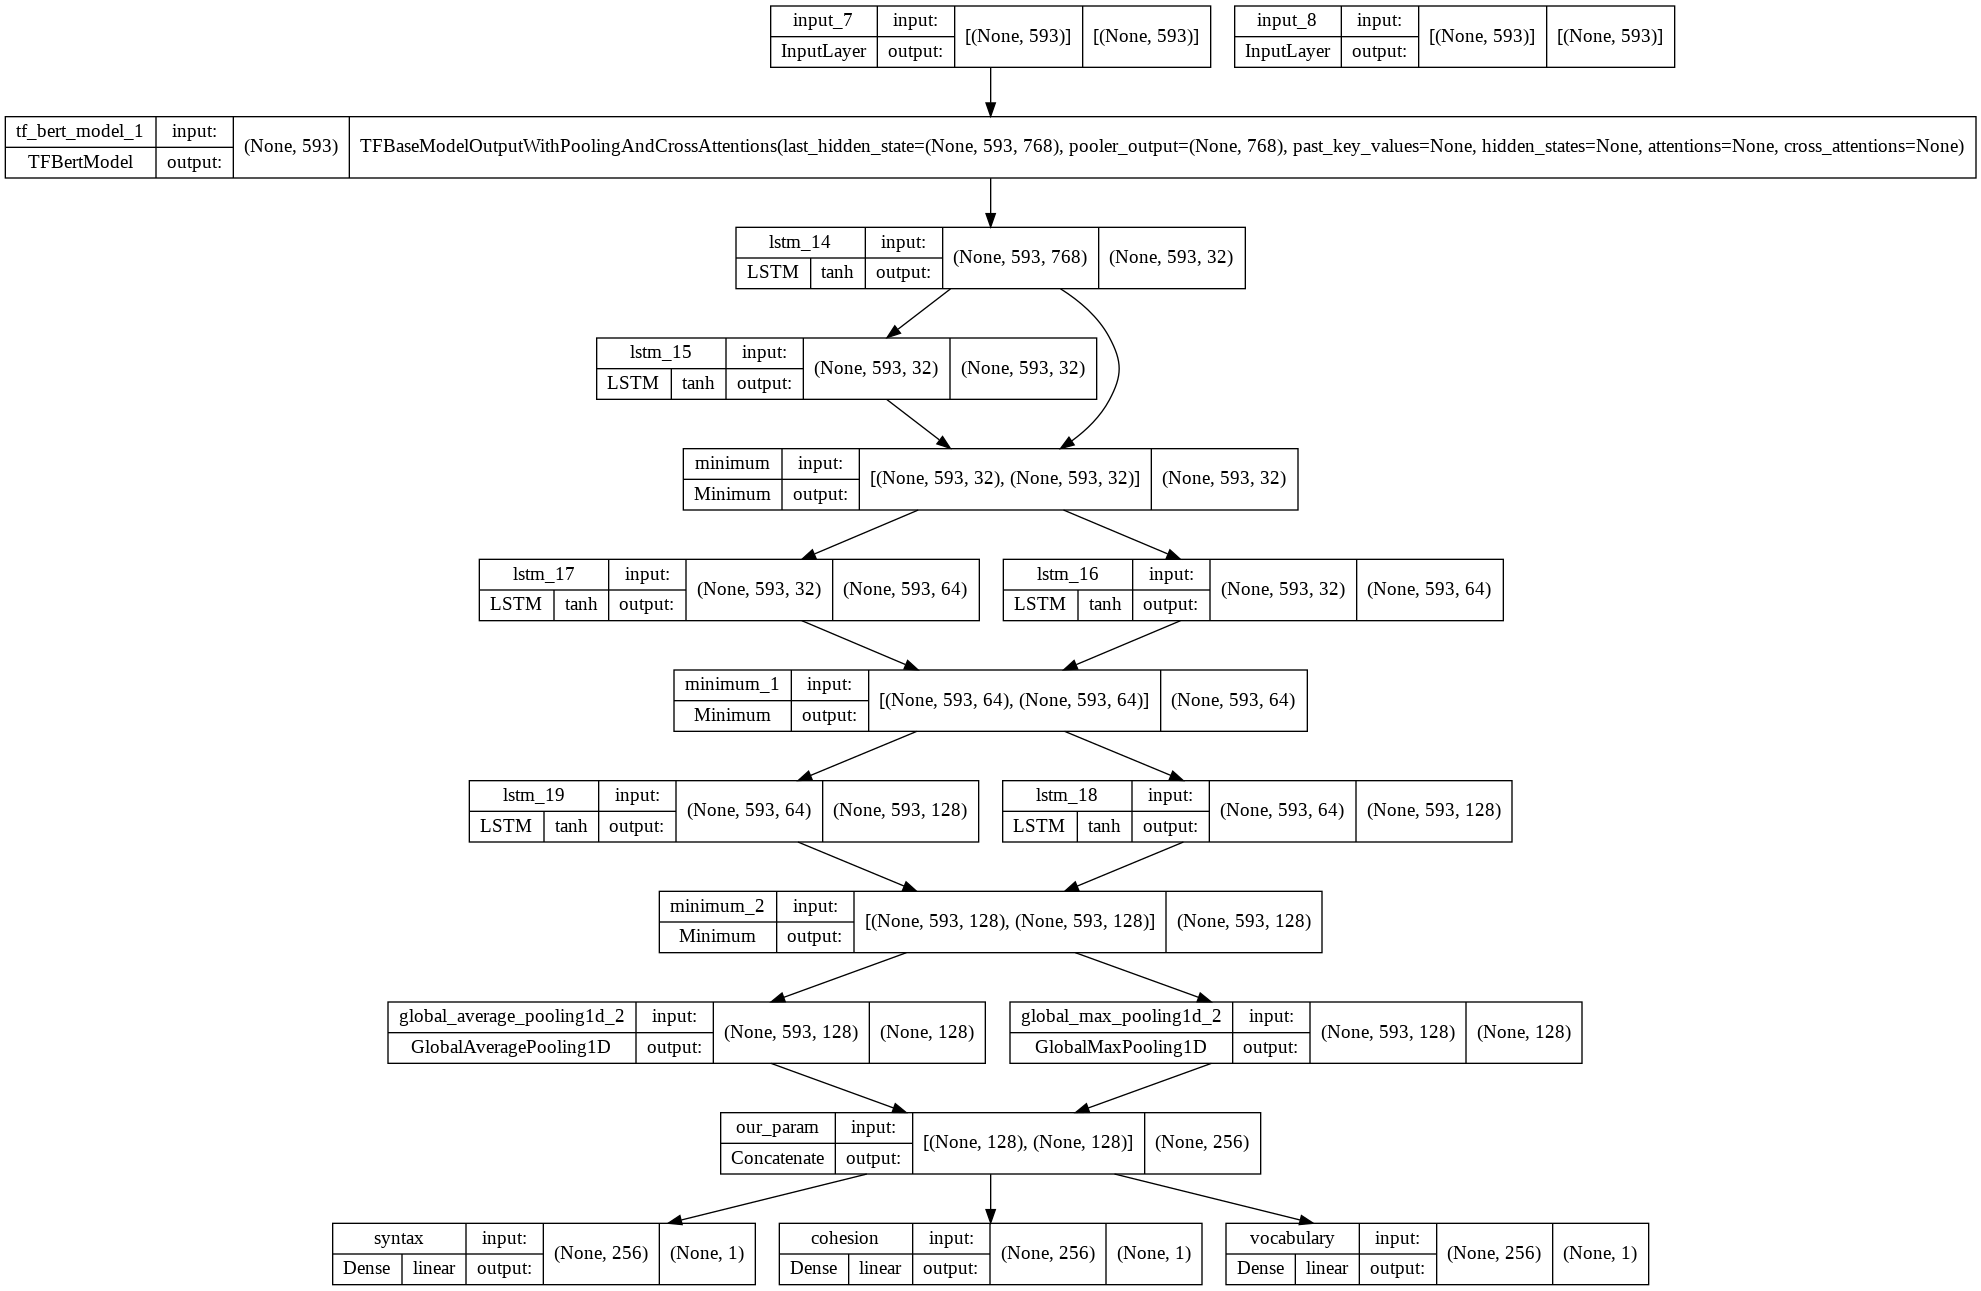

In [88]:
tf.keras.utils.plot_model(m, show_shapes=True, 
                          show_dtype=False, 
                          show_layer_names=True, 
                          expand_nested=True, 
                          show_layer_activations=True)

In [89]:
m.compile(loss="mse", optimizer= "adam")

In [90]:
history_training = m.fit([input_ids, attention_mask],
                         y = [syntax, cohesion, vocabulary],
                         batch_size= 1,
                         validation_split = 0.05, 
                         epochs= 6,
                         callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                                           factor=0.1, 
                                                                           mode = 'min',
                                                  patience= 1),
                             tf.keras.callbacks.EarlyStopping(patience = 2, 
                                                              monitor = 'val_loss', 
                                                              mode = 'min', 
                                                              restore_best_weights=True)])

Epoch 1/6
3715/3715 [==============================] - 10077s 3s/step - loss: 1.1463 - syntax_loss: 0.3995 - cohesion_loss: 0.4225 - vocabulary_loss: 0.3243 - val_loss: 0.7845 - val_syntax_loss: 0.3041 - val_cohesion_loss: 0.2726 - val_vocabulary_loss: 0.2078 - lr: 0.0010
Epoch 2/6
3715/3715 [==============================] - 10001s 3s/step - loss: 0.9498 - syntax_loss: 0.3335 - cohesion_loss: 0.3511 - vocabulary_loss: 0.2652 - val_loss: 0.8289 - val_syntax_loss: 0.3108 - val_cohesion_loss: 0.2978 - val_vocabulary_loss: 0.2204 - lr: 0.0010
Epoch 3/6
3715/3715 [==============================] - 10036s 3s/step - loss: 0.8373 - syntax_loss: 0.2956 - cohesion_loss: 0.3137 - vocabulary_loss: 0.2281 - val_loss: 0.6993 - val_syntax_loss: 0.2365 - val_cohesion_loss: 0.2713 - val_vocabulary_loss: 0.1916 - lr: 1.0000e-04
Epoch 4/6
3715/3715 [==============================] - 9969s 3s/step - loss: 0.8290 - syntax_loss: 0.2926 - cohesion_loss: 0.3102 - vocabulary_loss: 0.2262 - val_loss: 0.7044 - 

In [116]:
m.evaluate([input_ids, attention_mask],
                         y = [syntax, cohesion, vocabulary],
                         batch_size= 1)

3911/3911 [==============================] - 1890s 482ms/step - loss: 0.8003 - syntax_loss: 0.2848 - cohesion_loss: 0.3007 - vocabulary_loss: 0.2147


[0.8002532720565796,
 0.28483232855796814,
 0.30074042081832886,
 0.2146814912557602]

In [217]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [156]:
m.save("drive/MyDrive/feedbackmodel.h5")
m.save_weights("drive/MyDrive/feedbackmodel_weights.h5")

#Transfer Learning (Bert + ResNet LSTM)

In [234]:
import xgboost as xg

In [232]:
model = tf.keras.models.Model(
    m.input, 
    m.get_layer('our_param').output
)

In [134]:
x_train = [input_ids[:3300], attention_mask[:3300]]
x_test = [input_ids[3300:], attention_mask[3300:]]

In [135]:
X_train_features = model.predict(x_train)

In [136]:
X_test_features = model.predict(x_test)

In [137]:
X_train_features.shape

(3300, 256)

In [233]:
X_test_features.shape

(611, 256)

#Transfer Learning (Bert + ResNet LSTM) with XGBRegressor

In [138]:
from sklearn.metrics import mean_squared_error as MSE

In [218]:
def xgboost_syntax(data, x_train, x_test):
  data_y_train = data[:3300]
  data_y_test = data[3300:]
  xgb = xg.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 100)
  xgb.fit(x_train, data_y_train)
  y_pred = xgb.predict(x_test)
  loss_metrics = MSE(data_y_test, y_pred)
  return [y_pred, data_y_test, loss_metrics]

##Syntax Regression

In [219]:
[y_pred, y_true, loss_metrics] = xgboost_syntax(syntax, X_train_features, X_test_features)

In [220]:
loss_metrics

0.2994971788695396

In [221]:
pd.DataFrame({
    'y_pred': y_pred,
    'y_true': y_true,
    'loss': y_pred -  y_true
}).head(n= 30)

,y_pred,y_true,loss
0,3.382871,3.0,0.382871
1,2.780304,3.0,-0.219696
2,2.799982,2.5,0.299982
3,2.835058,3.0,-0.164942
4,3.134880,2.5,0.634880
5,2.433614,2.0,0.433614
6,2.300698,2.0,0.300698
7,2.600675,3.5,-0.899325
8,3.260674,2.5,0.760674
9,3.186303,3.0,0.186303


##Cohesion Regression

In [222]:
[y_pred, y_true, loss_metrics] = xgboost_syntax(cohesion, X_train_features, X_test_features)

In [223]:
loss_metrics

0.30764062967270756

In [224]:
pd.DataFrame({
    'y_pred': y_pred,
    'y_true': y_true,
    'loss': y_pred -  y_true
}).head(n= 30)

,y_pred,y_true,loss
0,3.461131,3.0,0.461131
1,2.929532,2.0,0.929532
2,2.837803,3.5,-0.662197
3,2.912138,2.5,0.412138
4,3.185733,2.5,0.685733
5,2.796054,3.5,-0.703946
6,2.558606,2.5,0.058606
7,2.642556,3.0,-0.357444
8,3.424440,2.5,0.924440
9,3.164848,3.5,-0.335152


##Vocabulary Regression

In [225]:
[y_pred, y_true, loss_metrics] = xgboost_syntax(vocabulary, X_train_features, X_test_features)

In [226]:
loss_metrics

0.2201188132420945

In [227]:
pd.DataFrame({
    'y_pred': y_pred,
    'y_true': y_true,
    'loss': y_pred -  y_true
}).head(n= 30)

,y_pred,y_true,loss
0,3.557647,3.5,0.057647
1,3.126863,2.5,0.626863
2,3.010127,3.0,0.010127
3,2.955162,2.5,0.455162
4,3.310529,3.0,0.310529
5,3.127928,3.0,0.127928
6,2.737059,2.5,0.237059
7,2.796192,3.5,-0.703808
8,3.450845,3.0,0.450845
9,3.245592,3.5,-0.254408


##Phraseology Regression

In [235]:
[y_pred, y_true, loss_metrics] = xgboost_syntax(phraseology, X_train_features, X_test_features)

In [236]:
loss_metrics

0.279147987968599

In [237]:
pd.DataFrame({
    'y_pred': y_pred,
    'y_true': y_true,
    'loss': y_pred -  y_true
}).head(n= 30)

,y_pred,y_true,loss
0,3.559639,4.0,-0.440361
1,3.021089,3.0,0.021089
2,2.874880,3.0,-0.125120
3,2.862811,2.5,0.362811
4,3.183568,3.0,0.183568
5,2.489570,2.5,-0.010430
6,2.529724,2.5,0.029724
7,2.506747,3.0,-0.493253
8,3.313673,2.5,0.813673
9,3.133345,3.0,0.133345


##Grammar Regression

In [238]:
[y_pred, y_true, loss_metrics] = xgboost_syntax(grammar, X_train_features, X_test_features)

In [239]:
loss_metrics

0.3888626417276952

In [240]:
pd.DataFrame({
    'y_pred': y_pred,
    'y_true': y_true,
    'loss': y_pred -  y_true
}).head(n= 30)

,y_pred,y_true,loss
0,3.505884,4.0,-0.494116
1,3.017936,3.0,0.017936
2,2.925714,3.5,-0.574286
3,2.984320,3.5,-0.515680
4,3.289282,2.5,0.789282
5,2.412958,2.5,-0.087042
6,2.344587,2.0,0.344587
7,2.526742,3.5,-0.973258
8,3.353337,2.5,0.853337
9,3.063531,3.5,-0.436469


##Conventions Regression

In [241]:
[y_pred, y_true, loss_metrics] = xgboost_syntax(conventions, X_train_features, X_test_features)

In [242]:
loss_metrics

0.28148406819585364

In [243]:
pd.DataFrame({
    'y_pred': y_pred,
    'y_true': y_true,
    'loss': y_pred -  y_true
}).head(n= 30)

,y_pred,y_true,loss
0,3.483822,3.0,0.483822
1,3.190214,2.5,0.690214
2,2.853128,3.5,-0.646872
3,2.777188,3.5,-0.722812
4,3.238925,2.5,0.738925
5,2.639908,2.5,0.139908
6,2.406075,3.0,-0.593925
7,2.300741,3.0,-0.699259
8,3.399169,2.5,0.899169
9,3.128091,3.0,0.128091
